# Deepfakes with GANs
> Re-enactment using Pix2Pix

Part-1 of this notebook covered training a pix2pix from scratch to generate Mr. Obama's face using facial landmarks only. In this second notebook, we will:
+ use the trained pix2pix GAN as our reenactment model
+ capture a live-feed from our camera and reenact Mr. Barak Obama in real-time

_This notebook assumes you have setup all dependencies and trained a model as shown in notebook 01._

## Load Libraries

In [1]:
import cv2
import dlib
import torch
import numpy as np
from PIL import Image
from imutils import video
from matplotlib import pyplot as plt

# import torch dependencies
from torch.autograd import Variable
import torchvision.transforms as transforms

# import utils
import gan_utils as gu
import dataset_utils as du

In [2]:
# instantiate objects for face and landmark detection
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [3]:
CUDA = True if torch.cuda.is_available() else False

## Instantiate and Load the trained GAN

In [4]:
# Initialize generator and discriminator
generator = gu.Generator()

# Loss functions
adversarial_loss = torch.nn.MSELoss()
pixelwise_loss = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
weight_pixel_wise_identity = 100

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [5]:
if CUDA:
    generator = generator.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()
    Tensor = torch.cuda.FloatTensor
else:
  Tensor = torch.FloatTensor

In [6]:
generator.load_state_dict(torch.load('saved_models/generator_230402.pt',
                                     map_location=torch.device('cpu')));
generator.eval();

## Utility to Prepare Video Frames for Model

In [7]:
def prepare_frame(frame):
    # resize frame
    frame_resize = cv2.resize(np.array(frame), 
                              None, 
                              fx=1 / du.DOWNSAMPLE_RATIO, 
                              fy=1 / du.DOWNSAMPLE_RATIO)
    # transform into gray scale
    gray = cv2.cvtColor(frame_resize, cv2.COLOR_BGR2GRAY)
    # detect face
    faces = detector(gray, 1)
    black_image = np.zeros(np.array(frame).shape, np.uint8)
    # get facial landmarks
    landmarks = du.get_landmarks(black_image.copy(),gray,faces,predictor)
    return frame_resize,landmarks

def get_reenactment(landmarks,generator):
    tx_landmarks = transforms.Resize((gu.IMG_HEIGHT, 
                                      gu.IMG_WIDTH), 
                                     Image.BICUBIC)(Image.fromarray(landmarks))
    tx_landmarks = transforms.ToTensor()(tx_landmarks)
    tx_landmarks = transforms.Normalize((0.5, 0.5, 0.5), 
                                        (0.5, 0.5, 0.5))(tx_landmarks)
    generator.eval()
    reenacted_frame = generator(Variable(tx_landmarks.type(Tensor)).unsqueeze(0))[0]
    reenacted_frame = 0.5 * reenacted_frame.detach().numpy() + 0.5
    return reenacted_frame,tx_landmarks

## Let's Reenact

/var/folders/54/t44fjw9105d4f066g0b729yr0000gn/T/ipykernel_20944/2999489053.py:44: RuntimeWarning: invalid value encountered in divide
  gen_imgs_0 = gen_imgs[0]/ gen_imgs[0].max()


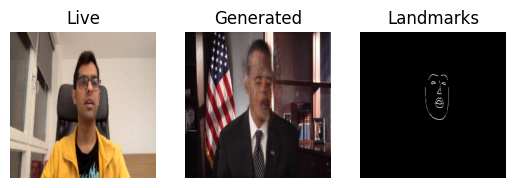

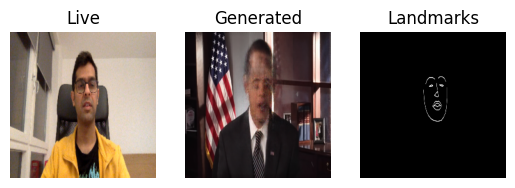

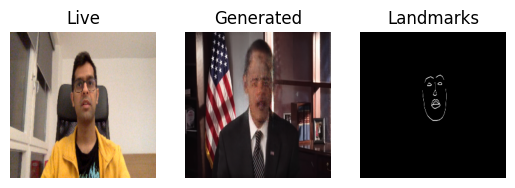

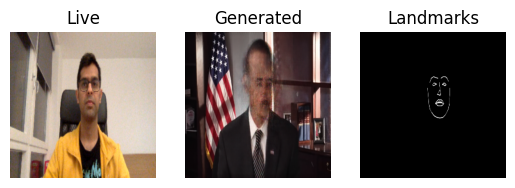

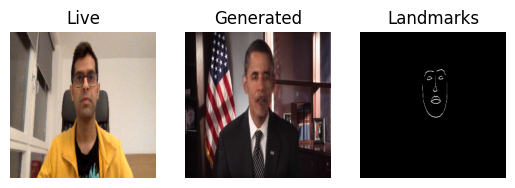

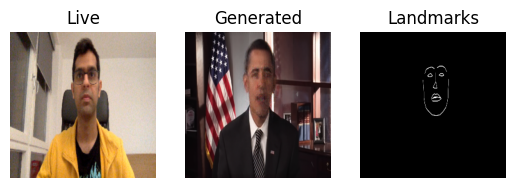

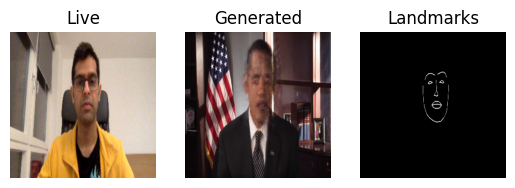

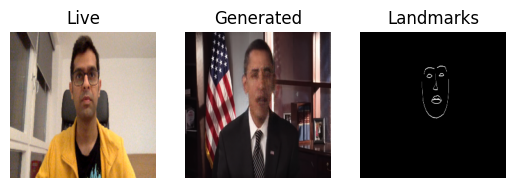

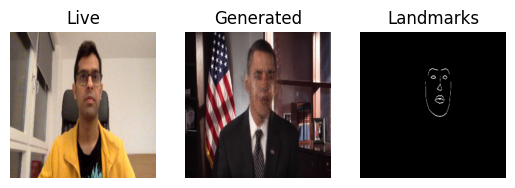

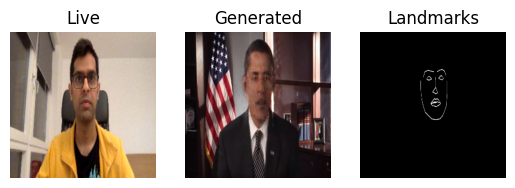

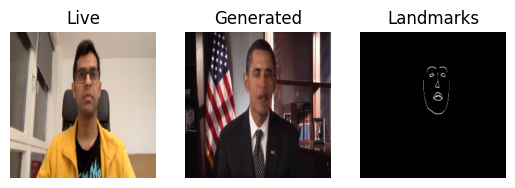

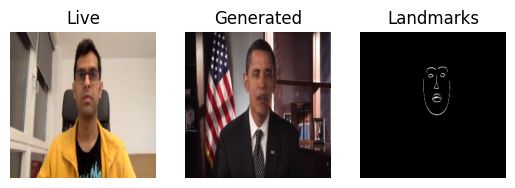

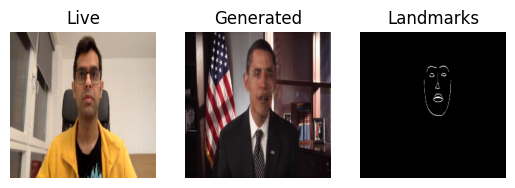

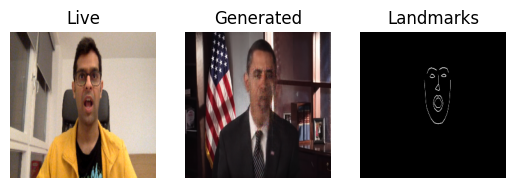

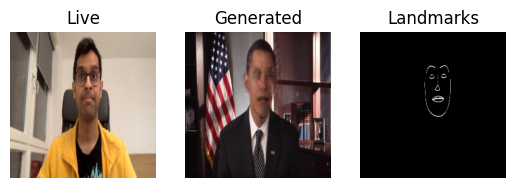

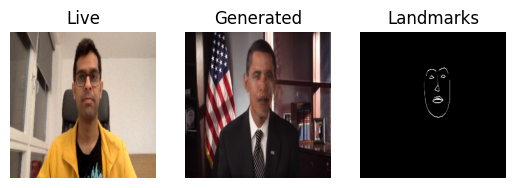

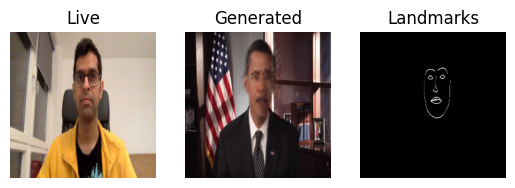

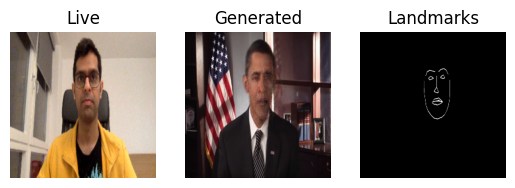

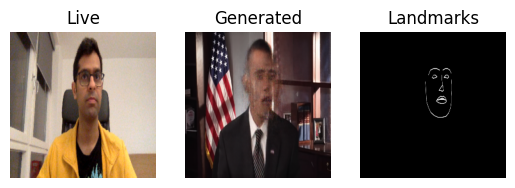

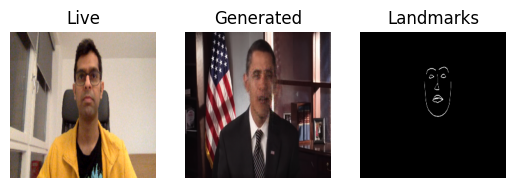

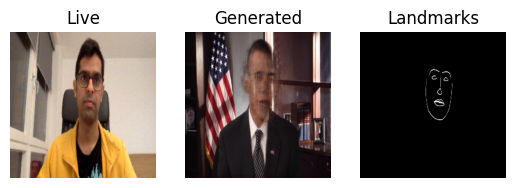

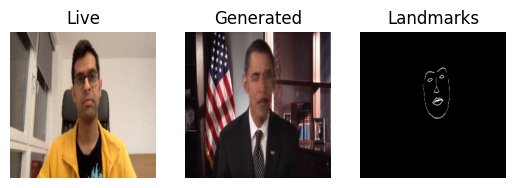

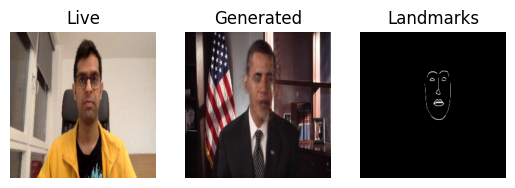

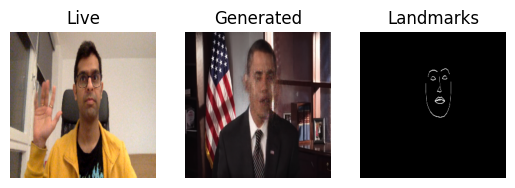

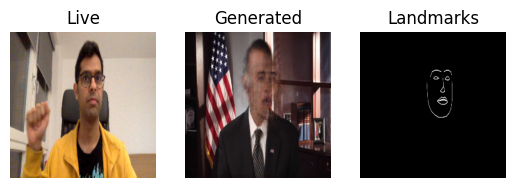

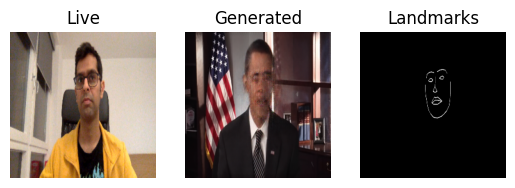

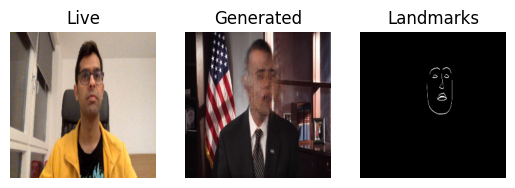

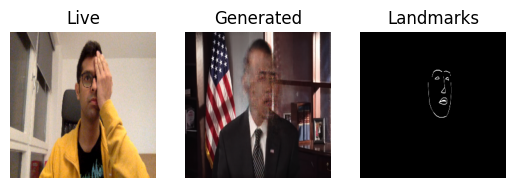

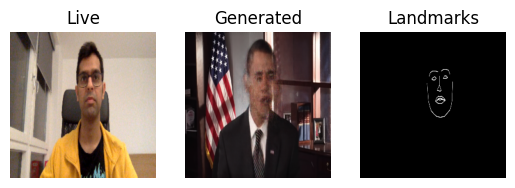

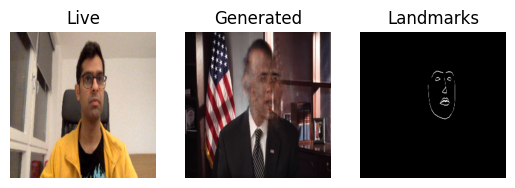

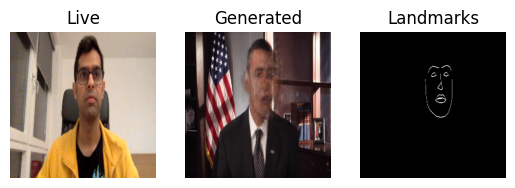

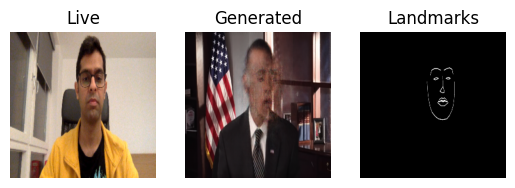

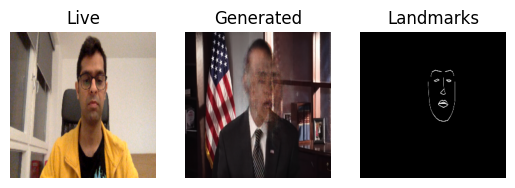

KeyboardInterrupt: 

In [8]:
cap = cv2.VideoCapture(0)
fps = video.FPS().start()
k = 0
display_plots = True
display_cv2 = True
while True:
    k += 1
    ret, frame = cap.read(0)
    if np.all(np.array(frame.shape)):
        try:
            # resize input video frame and get facial landmarks
            frame_resize,landmarks = prepare_frame(frame)
            # use pix2pix to get re-enacted frame using landmark
            reenacted_frame,tx_landmarks = get_reenactment(landmarks,generator)
            
            #concat all images
            gen_imgs = np.concatenate([
                                       np.expand_dims(cv2.cvtColor(
                                           du.rescale_frame(frame_resize), 
                                           cv2.COLOR_RGB2BGR
                                       ),axis=0),
                                       np.expand_dims(np.einsum('ijk->jki', 
                                                                reenacted_frame),
                                                      axis=0),
                                       np.expand_dims(np.einsum('ijk->jki', 
                                                                np.clip(tx_landmarks, 0, 1)),
                                                      axis=0)
            ])
            # display every 10th frame as a plot in the notebook
            if display_plots and k%10==0:
                titles = ['Live','Generated', 'Landmarks']
                rows, cols = 1, 3
                fig, axs = plt.subplots(rows, cols)
                for j in range(cols):
                    if j==0:
                        axs[j].imshow(gen_imgs[j].astype(int))
                    else:
                        axs[j].imshow(gen_imgs[j])
                    axs[j].set_title(titles[j])
                    axs[j].axis('off')
                plt.show()
            # display live feed
            if display_cv2:
                gen_imgs_0 = gen_imgs[0]/ gen_imgs[0].max()
                cv2.imshow('actor', cv2.cvtColor(gen_imgs_0, cv2.COLOR_BGR2RGB))
                cv2.imshow('synthetic obama', cv2.cvtColor(gen_imgs[1], cv2.COLOR_BGR2RGB))
                cv2.imshow('landmarks', cv2.cvtColor(gen_imgs[2], cv2.COLOR_BGR2RGB))
        except Exception as ex:
            print(ex)
        fps.update()
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
# close the live feed and processing
fps.stop()
print('[INFO] elapsed time (total): {:.2f}'.format(fps.elapsed()))
print('[INFO] approx. FPS: {:.2f}'.format(fps.fps()))

#sess.close()
cap.release()
cv2.destroyAllWindows()